# Row-wise convolutional encodings (maybe for TRT?)

### &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; *A hopefully helpful primer by Chase Shimmin (chase.shimmin@yale.edu) // October 29, 2020*

In today's AMLF meeting, Geoff Gaugler presented some very interesting work on using convolutional networks to improve particle ID in the TRT. The inputs to his 2D CNN are bitmap images that look like the following:


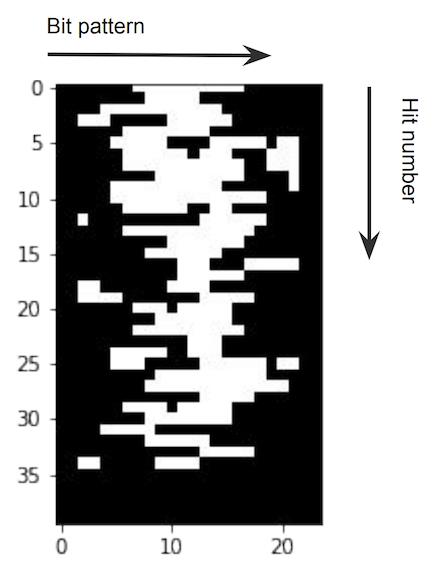

While Geoff shows some impressive results applying 2D CNNs, there may (or may not!) be room for improvement.
A 2D CNN essentially imbues a model with a structural prior of 2D shift-equivariance (discrete translations up/down/left/right) as well as feature locality (i.e. learned features are built from pixels adjacent in the plane).
Following some interesting discussion about the structure of these bitmap data, we propose an alternative achitecture that may be worth investigating.

By applying 1D convolutions and pooling along the time axis, where shift-equivariance is a reasonable prior, we can embed each bitstream of each row (corresponding to hits), into a single `K`-dimensional feature.
If the resulting collection of hits' features does not have a meaningful ordering, a deepsets-type architecture could be appropriate.
This uses a second latent encoding of each hit to a larger `L`-dimensional space, before taking the vector sum over all hits to yield a single `L`-dimensional feature to describe the whole event.
Alternatively, if the ordering of hits contains salient information, we can use an LSTM to learn a map from the ordered list of hits' features to a single `L`-dimensional latent encoding of the event.

Therefore, the proposed architecture might be expected to outperform a 2D CNN if either

    1) the ordering of the rows is irrelevant (deep sets) or
    2) correlations between non-adjacent rows are relevant (LSTM).
    
While both of these cases can in principle be addressed by the 2D CNN given a large enough receptive field, it may require more data and/or larger networks to do so.

Both of these models are fairly easy to implement using tensorflow 2 and tf.keras.
In this notebook, we demonstrate an example of each model on a toy dataset.
As a stand-in for TRT bitstreams, we use the well-known MNIST handwriting dataset.
And instead of performing the categorical task of particle ID, we will do the analogous task of digit recognition.

In [1]:
#### boilerplate includes for configuring GPUs on my workstation; ignore/modify as necessary.
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '1'

import tensorflow as tf
import tensorflow_probability as tfp

gpus = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpus[0], True)

In [2]:
# essential includes
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

## Dataset
Since I don't have any TRT bitstreams laying around, let's just grab good ol' MNIST.
This dataset is a collection of 60k 28x28 images; however, we will crop it a bit to break the symmetry a bit and make it easier to keep track of what the different axes represent. We'll also scale the data to be in the range [0,1].

After cropping and scaling, we're left with 60k 28x22 images.
We shall wantonly regard the axis of size 28 to represent "hit number" and the axis of size 22 to represent the "bit pattern".
Shown below is an example from the dataset corresponding to the label `y=5`:

x_train shape: (60000, 28, 22)


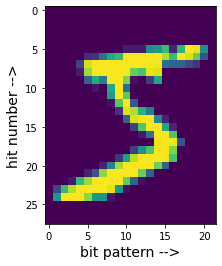

In [3]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train = x_train[:,:,3:-3]/255.
x_test = x_test[:,:,3:-3]/255.
print('x_train shape:', x_train.shape)

plt.imshow(x_train[0])
plt.xlabel("bit pattern -->")
plt.ylabel("hit number -->");

## Network implementation
Let's step through the network line-by-line. First we'll show the version based on deep-sets, and then we'll show the LSTM version with a minor modification.

### Adjust input tensor
First, we have to adjust the input tensor axes:

```python
x = tf.expand_dims(model_input, axis=-1)  # output shape: (?, 28, 22, 1)
```

For a 1D convolution, keras would would consider the (?, 28, 22) to mean 28 timesteps with 22 features at each.
But really we have 28 (independent?) channels, and each one has 22 timesteps with a single feature (just an on/off bit).
Therefore we can axis to our data to (?, 28, 22, 1), keras will treat this as a 1d convolution of one feature over 22 time steps.
The same exact convolutional kernel will be applied to the remaining axes (?, 28), i.e., it applies the same convolution
to each event and to each hit within events.

### 1D convolutions on the time axis

```python
x = layers.Conv1D(filters=K, kernel_size=3, strides=2, padding='same', activation='relu')(x)  # output shape: (?, 28, t=11, K)
```
If we apply a strided 1d convolution with `K` filters, we translate
the single bit at each time step into an encoding of `K` features.
The convolution also combines information about neighboring timesteps
(depending on kernel_size), so we end up with fewer time steps.
The result of the first convolution is that each of the 28 hits is summarized
by a 11-length "bitstream" with `K` abstract/learned features at each timestep.
The number of samples `t` in the time axis will be reduced by each convolution; the rate of downsampling depends on the kernel size and stride.
Using a strided convolution reduces `t` more quickly so
that you don't need too many layers, but it is also essentially
a form of decimation, so you might run into Nyquist sampling issues.
You can experiment with what works and combine strided and non-strided layers.
And just to emphasize: the exact same convolution in each layer will be applied independently
to each of the 28 hits.

```python
for _ in range(2):
    x = layers.Conv1D(filters=K, kernel_size=3, strides=2, padding='same', activation='relu')(x)  # output shape: (?, 28, t, K)
```

The goal is to get rid of the time axis entirely by summarizing each hit with
single point in say, a (`K=16`)-dimensional "latent space" encoding.
So we do a few more convolutions to reduce the timesteps further.
This time we are mapping the `K` previous features to a new set of `K`
features, and combining more timesteps.
Generally deeper representations can learn more interesting features.
The first layer might just do edge detection, or summing up bits.
Deeper layers might learn things that could, say, start looking like
energy estimates or have information about PID.
Of course, it's hard to interpret exactly what a NN has learned.
Note that the number of filters
doesn't need to be the same for all layers, but in any case I will
always refer to the number of filters in the final convolution as `K`.

Once we have reduced the time axis down a bit (in the example below, down to just `t=3` samples of `K`-dimensional features),
we can either keep doing convolutions or we can just do a final downsampling
with a pooling operation. Unfortunately Keras' maxpooling layers will
complain if you have more than 3 axes; but we can accomplish the same
thing with a simple tensorflow reduce operation.
We just have to take the maximum along the time axis:

```python
x = tf.reduce_max(x, axis=-2)  # output shape: (?, 28, K)
```

### Encode per-hit features
After convolution and pooling on the time axis, we are left with a single `K`-dimensional feature encoding for each
of our 28 hits. If there's no meaningful natural ordering between hits,
we can next apply a "deepsets" type architecture. The deepsets architecture
is permutation-invariant, so it is literally impossible for it to tell
the difference between any particular ordering of hits.
If the ordering of hits is salient, you could use an LSTM instead,
but they can be a lot slower to train.
The alternative LSTM implementation is given down below.

To build a "deep sets" network, we basically just apply a dense NN
to each of the 28 hits, and then sum the results.
As with the 1Dconv, this will be a single dense layer applied
identically to each of the 28 hits.
Recall that a dense layer with `N` units will translate the `K` feature
dimensions into `N` features.

```python
x = layers.Dense(100, activation='relu')(x)  # output shape: (?, 28, 100)
```

Now we have 100 features for each of the 28 hits. For deepsets it's
usually a good idea to increase and then decrease the hidden representation
size.

```python
x = layers.Dense(L, activation=None)(x)  # output shape: (?, 28, L)
```

Finally we reduce the per-hit representation to a lower-dimensional
latent encoding. The size `L` of this latent space will probably be an
very influential hyperparameter to tune.
Also, the choice of nonlinearity for this encoding can be important;
relu has a habit of permanantly "switching off" some of your channels,
so you might require a larger value of `L`.
Using no activation at all can sometimes be useful for this encoding as well.

So now we have a `L`-dimensional feature for each of our 28 hits.
The key to the deepsets architecture is that we simply add up
all of the `L`-dimensional vectors of each hit.
The remarkable result of the original deepsets paper is that
this network is in fact a universal approximator for arbitrary permutation-invariant functions.
Note that if you have a variable number of hits, you might
need to take care to mask out "empty" hits in this sum.

```python
x = tf.reduce_sum(x, axis=-2)  # output shape: (?, L)
```

### Network output
Finally, we are left with a single `L`-dimensional feature vector,
which encodes all the information about the entire collection of bitstreams.
The only thing left to do now is translate this encoding into whatever
is appropriate for your learning task; usually this is done by adding
a couple more dense layers to get the right final shape.
E.g. if you want to do an energy regression, you might output a single
number a mean-squared-error loss.
Since we're working with the MNIST dataset, we're going to do a categorical
output with 10 values; this is very similar to what we'd do for PID.

```python
x = layers.Dense(100, activation='relu')(x)  # output shape: (?, 100)
x = layers.Dense(10, activation=None)(x)     # output shape: (?, 10)
```

### Putting it together
To summarize: we first reduced each hit's bitstream into a K-dimensional
feature encoding, via 1D convolutions.
The idea is that the NN will learn to summarize the each timestream
into a single K-dimensional feature description.
Hence, we're left with a `28xK` tensor for each event.
Next, we used dense layers to encode those K-dimensional timestream encodings
into a (usually larger) latent space of size `L>K`.
This latent space has more "room" to store information,
which is important because we take the L-vector sum over all the hits.
Hence this latent space needs to enough space to store information about
the entire bitstreams of all the hits.
Finally, we added a few more NN layers to translate this encoding into
a categorical output for "PID" (or in this case, digit recognition).

The model described above is implemented in the following function, `trt_model()`:

In [4]:
def trt_model(K=16, L=32):
    model_input = layers.Input((28,22))
    
    print("model_input", model_input.shape)
    
    print("Append axis")
    x = tf.expand_dims(model_input, axis=-1)
    print('  x  ', x.shape)
    
    print("1D convolution")
    x = layers.Conv1D(filters=K, kernel_size=3, strides=2, padding='same', activation='relu')(x)
    print('  x  ', x.shape)
    
    for _ in range(2):
        print("1D convolution")
        x = layers.Conv1D(filters=K, kernel_size=3, strides=2, padding='same', activation='relu')(x)
        print('  x  ', x.shape)
    
    print("Maxpool 1D")
    x = tf.reduce_max(x, axis=-2)
    print('  x  ', x.shape)
    
    for _ in range(2):
        print("Dense (broadcasted)")
        x = layers.Dense(100, activation='relu')(x)
        print('  x  ', x.shape)

    
    print("Dense (broadcasted)")    
    x = layers.Dense(L, activation=None)(x)
    print('  x  ', x.shape)
    
    
    print("Latent sum")
    x = tf.reduce_sum(x, axis=-2)
    print('  x  ', x.shape)
    
    
    print("Dense")
    x = layers.Dense(100, activation='relu')(x)
    print('  x  ', x.shape)
    print("Output")
    x = layers.Dense(10, activation=None)(x)
    print('  x  ', x.shape)
    
    
    model = keras.Model(model_input, x)
    
    # set up the optimizer and loss function. NB: sparsecategorical just means we don't have to faff about with
    # converting y_true to a one-hot encoding.
    # Also note that from_logits=True only applies if you're not using softmax activation on the last layer.
    model.compile(optimizer='adam', loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['acc'])
    
    return model

### Instantiate model
Let's instantiate the model, and observe the printouts that help us understand the data representation at each layer.

In [5]:
keras.backend.clear_session()

model = trt_model()

history = {}

model_input (None, 28, 22)
Append axis
  x   (None, 28, 22, 1)
1D convolution
  x   (None, 28, 11, 16)
1D convolution
  x   (None, 28, 6, 16)
1D convolution
  x   (None, 28, 3, 16)
Maxpool 1D
  x   (None, 28, 16)
Dense (broadcasted)
  x   (None, 28, 100)
Dense (broadcasted)
  x   (None, 28, 100)
Dense (broadcasted)
  x   (None, 28, 32)
Latent sum
  x   (None, 32)
Dense
  x   (None, 100)
Output
  x   (None, 10)


Note that for such a deep network, it doesn't have very many parameters.
that is because of the extensive sharing of weights for the
convolution and dense layers which are broadcasted across the n-hits axis.

In [6]:
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 22)]          0         
_________________________________________________________________
tf_op_layer_ExpandDims (Tens [(None, 28, 22, 1)]       0         
_________________________________________________________________
conv1d (Conv1D)              (None, 28, 11, 16)        64        
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 28, 6, 16)         784       
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 28, 3, 16)         784       
_________________________________________________________________
tf_op_layer_Max (TensorFlowO [(None, 28, 16)]          0         
_________________________________________________________________
dense (Dense)                (None, 28, 100)          

### Deepsets model training
Since this is just a straightforward categorization task, we can simply call `model.fit()` to train the network.

In [13]:
h = model.fit(x_train, y_train,
          validation_data=(x_test, y_test),
          epochs=10, batch_size=128,
         )

for k,v in h.history.items():
    history.setdefault(k, []).extend(v)

Epoch 1/10
469/469 [==============================] - 3s 6ms/step - loss: 0.2307 - acc: 0.9239 - val_loss: 0.3008 - val_acc: 0.9034
Epoch 2/10
469/469 [==============================] - 3s 6ms/step - loss: 0.2221 - acc: 0.9269 - val_loss: 0.2916 - val_acc: 0.9095
Epoch 3/10
469/469 [==============================] - 3s 6ms/step - loss: 0.2217 - acc: 0.9258 - val_loss: 0.2818 - val_acc: 0.9097
Epoch 4/10
469/469 [==============================] - 3s 6ms/step - loss: 0.2152 - acc: 0.9290 - val_loss: 0.3111 - val_acc: 0.9037
Epoch 5/10
469/469 [==============================] - 3s 6ms/step - loss: 0.2135 - acc: 0.9294 - val_loss: 0.2899 - val_acc: 0.9115
Epoch 6/10
469/469 [==============================] - 3s 6ms/step - loss: 0.2085 - acc: 0.9309 - val_loss: 0.2947 - val_acc: 0.9053
Epoch 7/10
469/469 [==============================] - 2s 5ms/step - loss: 0.2065 - acc: 0.9310 - val_loss: 0.2908 - val_acc: 0.9083
Epoch 8/10
469/469 [==============================] - 3s 6ms/step - loss: 0.

### Deepsets network results
The model achives ~91% accuracy before the training loss begins to diverge from the validation loss.
We're not going to win any awards for highest MNIST score, but it shows that the network works.

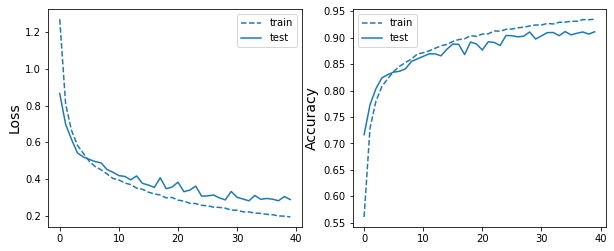

In [14]:
plt.figure(figsize=plt.figaspect(0.4))
plt.subplot(121)
plt.plot(history['loss'], label='train', color='C0', ls='--')
plt.plot(history['val_loss'], label='test', color='C0')
plt.legend()
plt.ylabel("Loss")
plt.subplot(122)
plt.plot(history['acc'], label='train', color='C0', ls='--')
plt.plot(history['val_acc'], label='test', color='C0')
plt.legend()
plt.ylabel("Accuracy");

## LSTM Implementation
Let's do the same thing, but swap out the deepsets part of the network for an LSTM.

The change happens here:
```python
# max pooling of 1D conv, as before:
x = tf.reduce_max(x, axis=-2)  # output shape: (?, 28, K)

# first LSTM returning sequence of the same length
x = layers.LSTM(units=100, return_sequences=True)(x)  # output shape: (?, 28, 100)

# last LSTM, return only the L features of the output unit.
x = layers.LSTM(units=L, return_sequences=False)(x)   # output shape: (?, L)

# feed into output layers, as before:
x = layers.Dense(100, activation='relu')(x)  # output shape: (?, 100)
x = layers.Dense(10, activation=None)(x)     # output shape: (?, 10)
```

This shows we can achieve the same overall network structure using stacked LSTMs instead of deepsets.
The first LSTM projects our `K`-dimensional features
for each hit into 100-dim representation. This step could be optional, or you could include multiple layers of LSTMs here; stacking more LSTMs
will slow things down considerably.
The second LSTM reduces the representation to dimension `L`, and
squashes the hit-number axis (by returning only the final output of the LSTM).
So as before, we end up with a single L-dimensional feature for each event.

In [15]:
def trt_model_lstm():
    model_input = layers.Input((28,22))
    
    print("model_input", model_input.shape)    
    print("Append axis")
    x = tf.expand_dims(model_input, axis=-1)
    print('  x  ', x.shape)
    
    K = 16
    print("1D convolution")
    x = layers.Conv1D(filters=K, kernel_size=3, strides=2, padding='same', activation='relu')(x)
    print('  x  ', x.shape)
    
    for _ in range(2):
        print("1D convolution")
        x = layers.Conv1D(filters=K, kernel_size=3, strides=2, padding='same', activation='relu')(x)
        print('  x  ', x.shape)
    
    print("Maxpool 1D")
    x = tf.reduce_max(x, axis=-2)
    print('  x  ', x.shape)
    
    L = 32
    print('LSTM')
    x = layers.LSTM(units=100, return_sequences=True)(x)
    print('  x  ', x.shape)
    
    print('LSTM')
    x = layers.LSTM(units=L, return_sequences=False)(x)
    print('  x  ', x.shape)
    
    print("Dense")
    x = layers.Dense(100, activation='relu')(x)
    print('  x  ', x.shape)
    print("Output")
    x = layers.Dense(10, activation=None)(x)
    print('  x  ', x.shape)
    
    model = keras.Model(model_input, x)
    model.compile(optimizer='adam', loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['acc'])
    
    return model

### LSTM model training
We can train the LSTM model in the same way as before:

In [16]:
model_lstm = trt_model_lstm()

history_lstm = {}

model_input (None, 28, 22)
Append axis
  x   (None, 28, 22, 1)
1D convolution
  x   (None, 28, 11, 16)
1D convolution
  x   (None, 28, 6, 16)
1D convolution
  x   (None, 28, 3, 16)
Maxpool 1D
  x   (None, 28, 16)
LSTM
  x   (None, 28, 100)
LSTM
  x   (None, 32)
Dense
  x   (None, 100)
Output
  x   (None, 10)


Note that the LSTM has substantially more parameters than the DS network, even though it has one fewer layers.

In [17]:
model_lstm.summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 28, 22)]          0         
_________________________________________________________________
tf_op_layer_ExpandDims_1 (Te [(None, 28, 22, 1)]       0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 28, 11, 16)        64        
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 28, 6, 16)         784       
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 28, 3, 16)         784       
_________________________________________________________________
tf_op_layer_Max_1 (TensorFlo [(None, 28, 16)]          0         
_________________________________________________________________
lstm (LSTM)                  (None, 28, 100)          

In [25]:
h = model_lstm.fit(x_train, y_train,
          validation_data=(x_test, y_test),
          epochs=10, batch_size=128,
         )

for k,v in h.history.items():
    history_lstm.setdefault(k, []).extend(v)

Epoch 1/10
469/469 [==============================] - 4s 10ms/step - loss: 0.0138 - acc: 0.9953 - val_loss: 0.0403 - val_acc: 0.9892
Epoch 2/10
469/469 [==============================] - 5s 11ms/step - loss: 0.0108 - acc: 0.9965 - val_loss: 0.0349 - val_acc: 0.9900
Epoch 3/10
469/469 [==============================] - 5s 10ms/step - loss: 0.0111 - acc: 0.9964 - val_loss: 0.0454 - val_acc: 0.9883
Epoch 4/10
469/469 [==============================] - 4s 10ms/step - loss: 0.0133 - acc: 0.9959 - val_loss: 0.0407 - val_acc: 0.9885
Epoch 5/10
469/469 [==============================] - 5s 11ms/step - loss: 0.0062 - acc: 0.9980 - val_loss: 0.0429 - val_acc: 0.9888
Epoch 6/10
469/469 [==============================] - 5s 10ms/step - loss: 0.0116 - acc: 0.9962 - val_loss: 0.0490 - val_acc: 0.9873
Epoch 7/10
469/469 [==============================] - 5s 11ms/step - loss: 0.0072 - acc: 0.9978 - val_loss: 0.0448 - val_acc: 0.9875
Epoch 8/10
469/469 [==============================] - 5s 11ms/step - 

# Comparison of results
Here we show the training curves of the Deepsets and LSTM architectures overlaid:

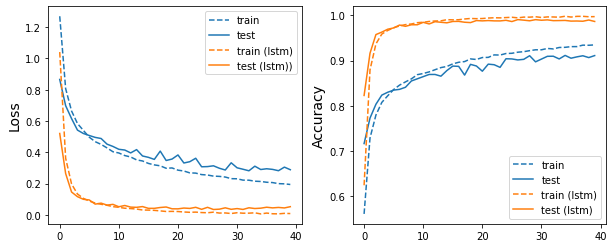

In [26]:
plt.figure(figsize=plt.figaspect(0.4))
plt.subplot(121)
plt.plot(history['loss'], label='train', color='C0', ls='--')
plt.plot(history['val_loss'], label='test', color='C0')
plt.plot(history_lstm['loss'], color='C1', ls='--', label='train (lstm)')
plt.plot(history_lstm['val_loss'], color='C1', label='test (lstm))')
plt.legend()
plt.ylabel("Loss")
plt.subplot(122)
plt.plot(history['acc'], label='train', color='C0', ls='--')
plt.plot(history['val_acc'], label='test', color='C0')
plt.plot(history_lstm['acc'], color='C1', ls='--', label='train (lstm)')
plt.plot(history_lstm['val_acc'], color='C1', label='test (lstm)')
plt.legend()
plt.ylabel("Accuracy");

# Discussion
As we can see, the LSTM-based model does *much* better, and in far fewer epochs.
This is not surprising, given that the task is to recognize digits.
Clearly, the ordering of the pixel rows is important for this purpose.
Since the deep sets version of this architecture is, by design, invariant w.r.t. permutation or rows, it is at a disadvantage.

Consider for example the following cartoon:

```
 row0     @@@@@        permute          @@@@@
 row1        @@        rows (1,3)       @@
 row2     @@@@@    ---------------->    @@@@@
 row3     @@                               @@
 row4     @@@@@                         @@@@@
```
The deep sets architecture will respond exactly the same to both of these inputs.
Therefore, it will fail to distinguish between these idealized versions of the digits 2 and 5.

Still, this suggests a possible issue that arises when different digits have even somewhat similar rows.
We can directly check this hypothesis by looking at the confusion matrices of each network.
The z-scale has been exaggerated to demonstrate the point, but as we can see, the DS network does indeed struggle with mislabeling 2's as 5's and visa vera!
The only distinct confusion feature of the LSTM-based model is between digits 4 and 9, which is an understandable mistake even for humans.

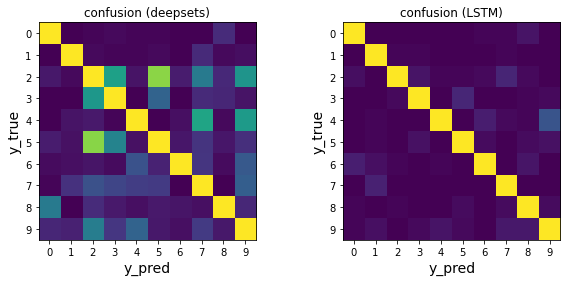

In [32]:
preds_deepsets = np.argmax(model.predict(x_test), axis=-1)
preds_lstm = np.argmax(model_lstm.predict(x_test), axis=-1)

plt.figure(figsize=plt.figaspect(0.4))
plt.subplot(121)
plt.imshow(confusion_matrix(y_test, preds_deepsets, normalize='true'), vmax=0.075)
plt.xticks(np.arange(10));
plt.yticks(np.arange(10));
plt.ylabel("y_true");
plt.xlabel("y_pred");
plt.title("confusion (deepsets)");
plt.subplot(122)
plt.imshow(confusion_matrix(y_test, preds_lstm, normalize='true'), vmax=0.075)
plt.xticks(np.arange(10));
plt.yticks(np.arange(10));
plt.ylabel("y_true");
plt.xlabel("y_pred");
plt.title("confusion (LSTM)");

# Conclusion

The conclusion of this study is *not* to say that LSTM is better than deepsets, in general.
Instead, we find that the LSTM performs better in this case due to a specific feature of the data that is modeled better by an LSTM.
Note that both of these models certainly do worse than 2D CNNs on this task; again, not surprising given CNNs were designed specifically for this kind of task.

The takeaway is that we have to consider representational properties of the data we're modeling when designing a NN achitecture.
In the case of jet tagging, it has been observed that DS networks perform at least as well as LSTMs, but train much faster.
This is because the jet tagging problem considers as input a list of, say, 4-momenta (pt, eta, phi, mass).
All of the relevant structural information for the task is encoded in the geometry of these inputs; the order in which they are presented is completely irrelevant (and indeed must be arbitrarily chosen).
However, as we see in the MNIST, example, DS may not be suitable if there is important information encoded in the ordering of inputs.
If we had arbitrarily chosen to randomize the order of MNIST pixel rows (to represent, say, some kind of non-deterministic detector sampling), we might expect that the deepsets-based model would perform at least as well as any other.